In [340]:
import sys
import os

import os
cwd = os.getcwd()
root_path = os.path.abspath('..')
sys.path.insert(0, root_path)


In [341]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.fs import RESULTS_RAW_DIR

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from utils.enums import Perspective

In [342]:
def get_latest_run():
    def is_numeric(input):
        try:
            float(input)
            return True
        except ValueError:
            return False
        
    numeric_folders = [folder for folder in os.listdir(RESULTS_RAW_DIR) if is_numeric(folder) and os.path.isdir(os.path.join(RESULTS_RAW_DIR, folder))]

    if numeric_folders:
        highest_number = max(float(folder) for folder in numeric_folders)
        print(f"The latest run is: {highest_number}")
        return str(highest_number)
    else:
        print("No runs found.")
        return None

In [343]:
def load_results(run_name):
    run_path = os.path.join(RESULTS_RAW_DIR, run_name)
    npy_files = [file for file in os.listdir(run_path) if file.endswith('.npy')]

    loaded_data = {}

    # Load each .npy file and use the file name (without extension) as the key
    for npy_file in npy_files:
        file_path = os.path.join(run_path, npy_file)
        key = os.path.splitext(npy_file)[0]  # Get the file name without .npy extension
        loaded_data[key] = np.load(file_path)

        print(f"{loaded_data[key].shape} \t {key}")

    return loaded_data

In [344]:
latest_run = get_latest_run()
results = load_results(run_name=latest_run) 

# '1726688270.265151' 0.05 anomaly rate
# '1726683337.723001' 0.25
# '1726688845.1876202' 0.05 with 0.25 noise
# '1726688947.9127235' 0.25 with 0.25 noise
# '1726689265.3127506' 0.05 with 1 noise
# '1726689364.887093' 0.25 with 1 noise

The latest run is: 1726689364.887093
(41999, 15, 10, 4) 	 labels_DAE_attribute
(41999, 15, 4) 	 labels_DAE_event
(41999, 4) 	 labels_DAE_trace
(5250,) 	 losses_DAE
(41999, 15, 1) 	 result_DAE_attribute_Arrival Time
(41999, 15, 4) 	 result_DAE_attribute_Attribute
(41999, 15, 1) 	 result_DAE_attribute_Order
(41999, 15, 4) 	 result_DAE_attribute_Workload
(41999, 15) 	 result_DAE_event_Arrival Time
(41999, 15) 	 result_DAE_event_Attribute
(41999, 15) 	 result_DAE_event_Order
(41999, 15) 	 result_DAE_event_Workload
(41999,) 	 result_DAE_trace_Arrival Time
(41999,) 	 result_DAE_trace_Attribute
(41999,) 	 result_DAE_trace_Order
(41999,) 	 result_DAE_trace_Workload


In [355]:
# Check the amount of anomalies of each type are present
print(np.sum(results['labels_DAE_trace'][:,0] == 1))
print(np.sum(results['labels_DAE_trace'][:,1] == 1))
print(np.sum(results['labels_DAE_trace'][:,2] == 1))
print(np.sum(results['labels_DAE_trace'][:,3] == 1))

print(len(results['labels_DAE_trace']))

2697
3450
3050
40647
41999


In [346]:
def plot_losses_fancy(results, labels, perspective, zoom=[[11000,13000],[-0.05, 0.2]]):
    def scatter_plot(ax, results, labels):
        y_values = results
        x_values = np.arange(len(results))
        ax.scatter(x_values[labels == 0], y_values[labels == 0], c='grey', s=3, label='Normal Prefixes', zorder=1)
        ax.scatter(x_values[labels == 1], y_values[labels == 1], c='red', s=3, label='Anomalous Prefixes', zorder=2)
        ax.grid(True)

    fig, ax = plt.subplots(figsize=(15, 6))

    labels = labels[:, perspective]
    scatter_plot(ax, results, labels)
    
    perspective_name = Perspective.values()[perspective]
    plt.title(f'Error per Prefix on the {perspective_name} perspective')
    plt.xlabel('Prefix Index')
    plt.ylabel('Loss')
    
    if zoom:
        axins = inset_axes(ax, width="60%", height="60%", loc='upper right')

        scatter_plot(axins, results, labels)
        axins.set_xlim(zoom[0])
        axins.set_ylim(zoom[1])
        _,_ = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=3)

    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

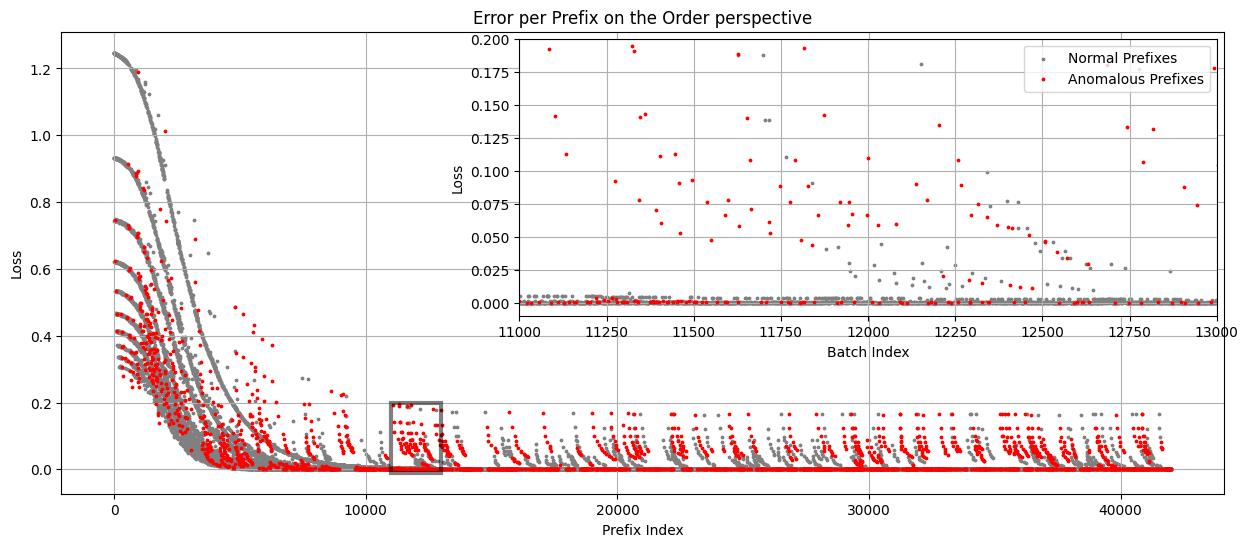

In [347]:
plot_losses_fancy(
    results=results['result_DAE_trace_Order'], 
    labels=results['labels_DAE_trace'], 
    perspective=Perspective.ORDER, 
    zoom=[[11000,13000],[-0.01, 0.2]])

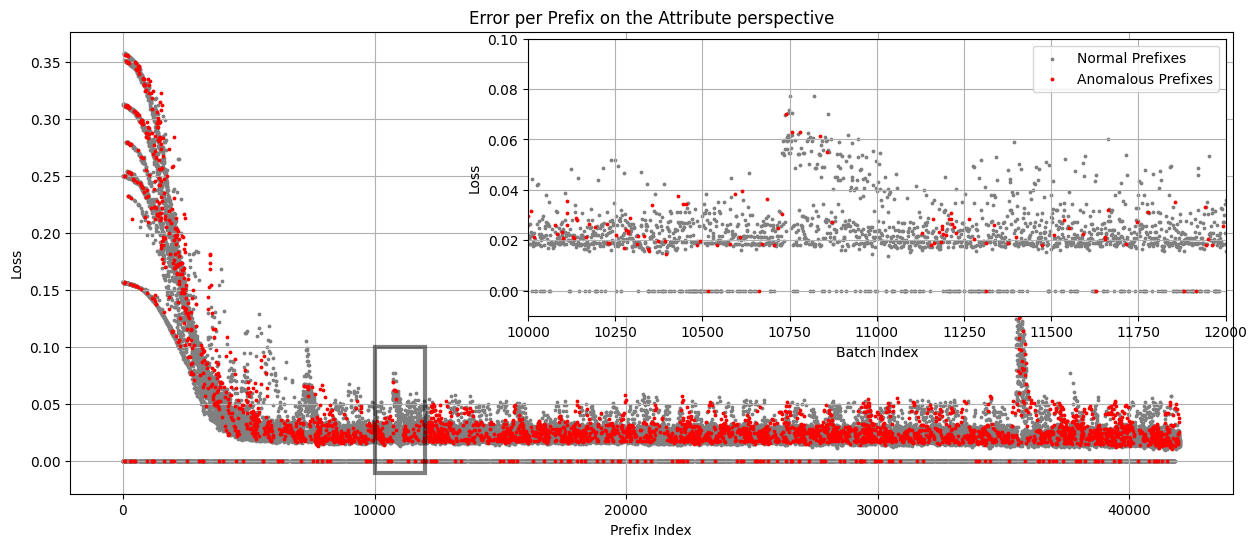

In [348]:
plot_losses_fancy(
    results=results['result_DAE_trace_Attribute'], 
    labels=results['labels_DAE_trace'], 
    perspective=Perspective.ATTRIBUTE,
    zoom=[[10000,12000],[-0.01, 0.1]])

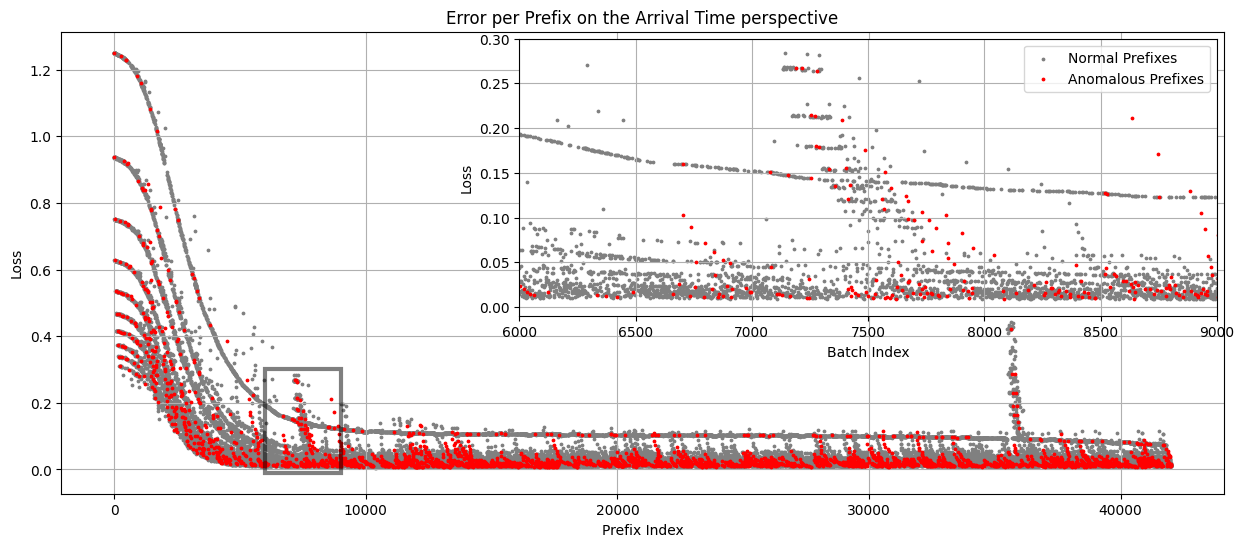

In [349]:
plot_losses_fancy(
    results=results['result_DAE_trace_Arrival Time'], 
    labels=results['labels_DAE_trace'], 
    perspective=Perspective.ARRIVAL_TIME,
    zoom=[[6000,9000],[-0.01, 0.3]])

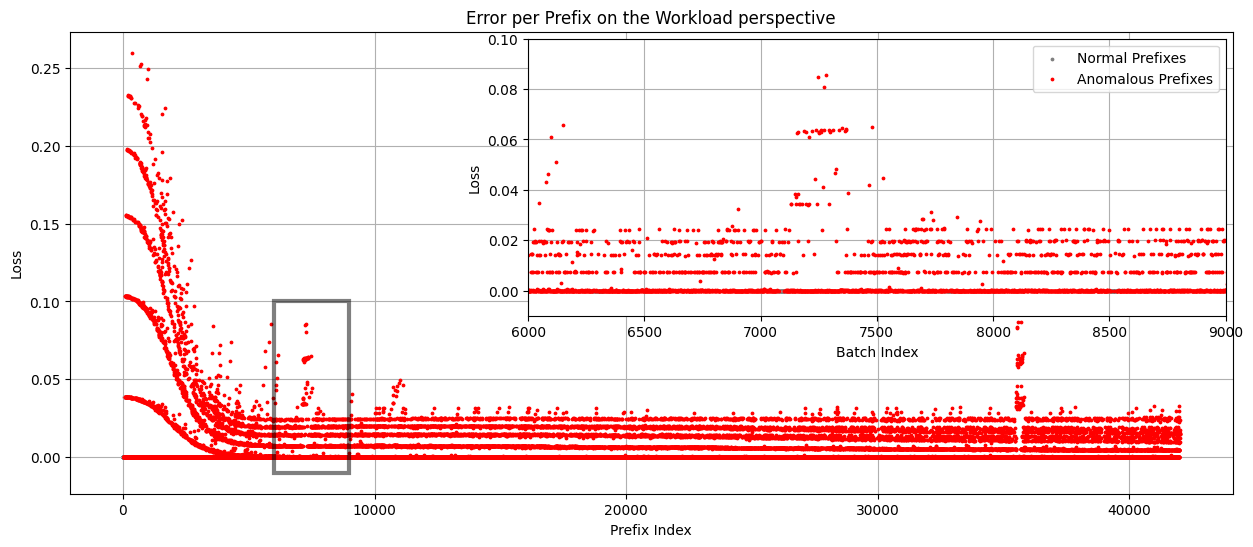

In [350]:
plot_losses_fancy(
    results=results['result_DAE_trace_Workload'], 
    labels=results['labels_DAE_trace'], 
    perspective=Perspective.WORKLOAD,
    zoom=[[6000,9000],[-0.01, 0.1]])

In [358]:
results['result_DAE_event_Order'].reshape(-1, 1).shape

(629985, 1)

In [360]:
results['labels_DAE_event'].reshape(-1, 4).shape

(629985, 4)

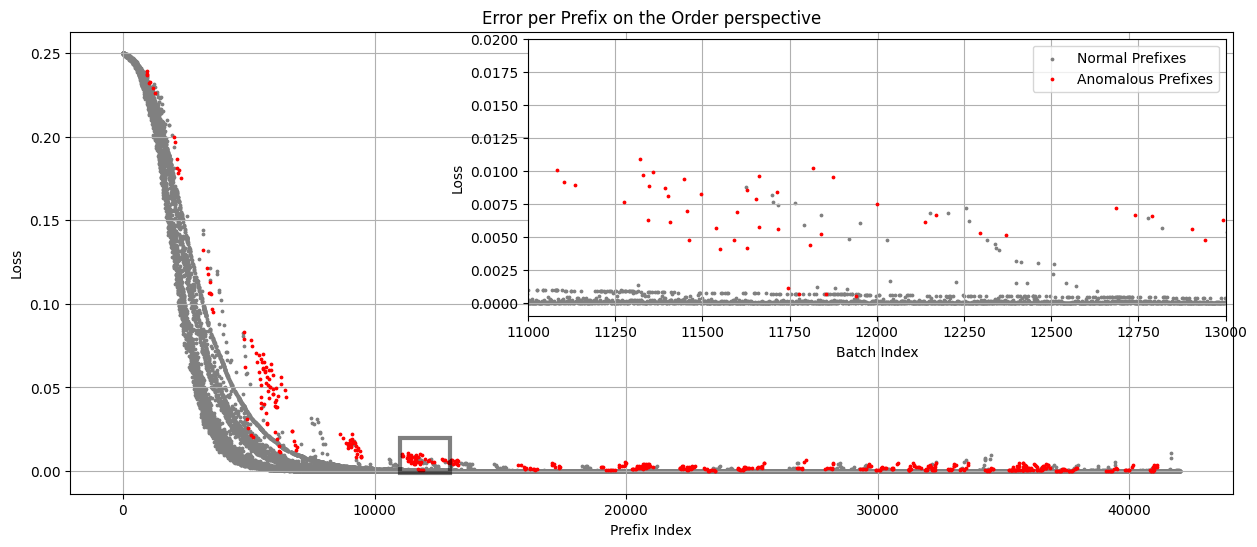

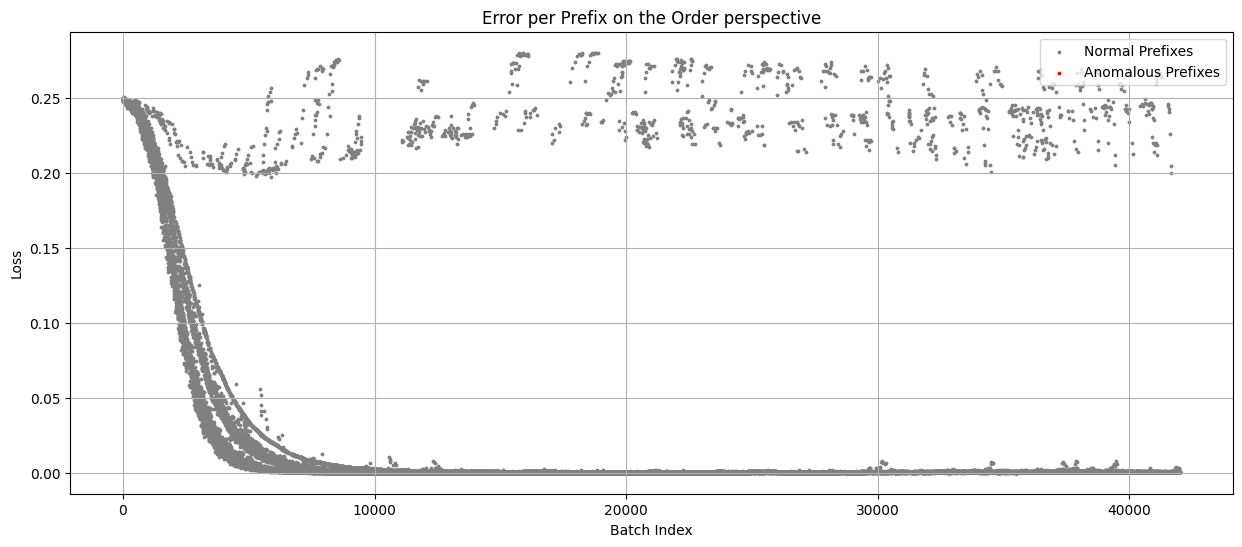

In [386]:
event_index = 0
plot_losses_fancy(
    results=results['result_DAE_event_Order'][:,event_index], 
    labels=results['labels_DAE_event'][:,event_index], 
    perspective=Perspective.ORDER,
    zoom=[[11000,13000],[-0.001, 0.02]])
event_index = 12
plot_losses_fancy(
    results=results['result_DAE_event_Order'][:,event_index], 
    labels=results['labels_DAE_event'][:,event_index], 
    perspective=Perspective.ORDER,
    zoom=None)

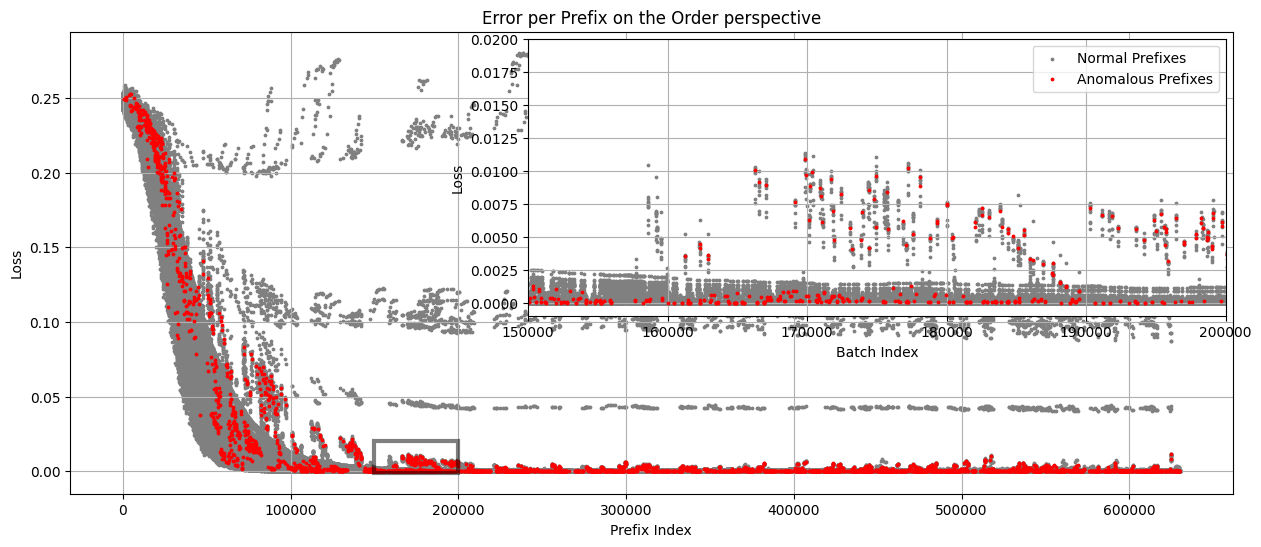

In [364]:
plot_losses_fancy(
    results=results['result_DAE_event_Order'].reshape(-1, 1), 
    labels=results['labels_DAE_event'].reshape(-1, 4), 
    perspective=Perspective.ORDER,
    zoom=[[150000,200000],[-0.001, 0.02]])

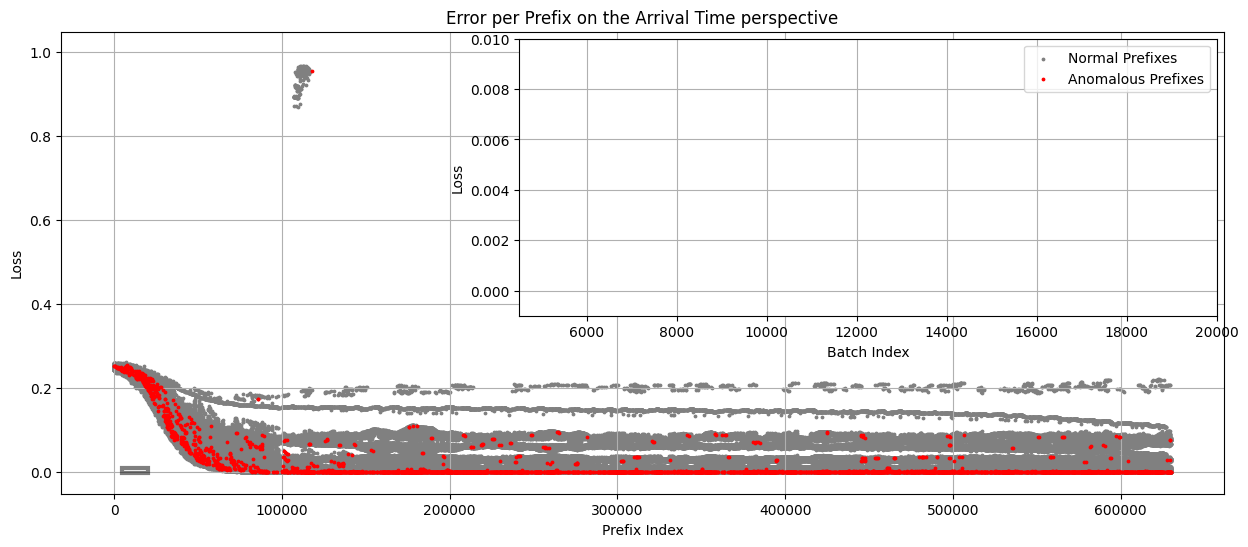

In [362]:
plot_losses_fancy(
    results=results['result_DAE_event_Arrival Time'].reshape(-1, 1), 
    labels=results['labels_DAE_event'].reshape(-1, 4), 
    perspective=Perspective.ARRIVAL_TIME,
    zoom=[[4500,20000],[-0.001, 0.01]])